In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
% ls -1 data/

test_seas2_0.871.csv
test_seas_0.104.csv


In [3]:
df_01 = pd.read_csv('data/test_seas_0.104.csv')
df_09 = pd.read_csv('data/test_seas2_0.871.csv')

In [4]:
df_01.shape

(200, 10000)

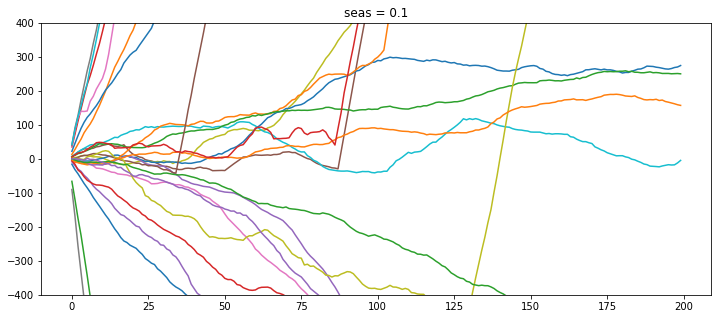

In [5]:
df_01.sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           legend=False, figsize=(12,5),
           ylim=(-400,400),
           title='seas = 0.1'
          );

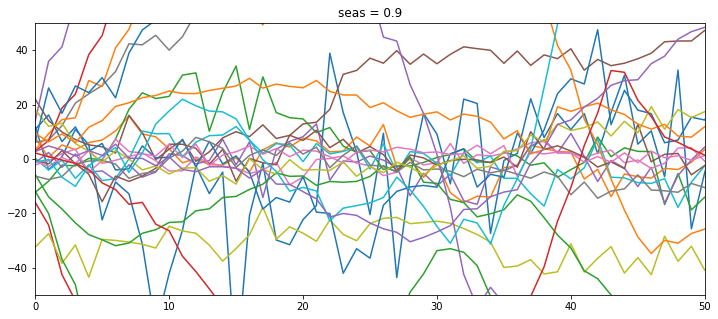

In [6]:
df_09.sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

## Preprocessing

## Making datasets + Preprocessing
We do following:

1) add min value to makes TS positive.

2) log.

3) divide by max in order to make $TS \in [0,1]$.


In [7]:
def norm_ts(data):
    """
    1) add min value to makes TS positive. 
    2) log. 
    3) divide by max in order to make  TS∈[0,1] .
    """
    min_val = np.min(data)
    data_log = np.log(data - min_val + 1)
    
    max_val_after_log = np.max(data_log)
    return data_log / max_val_after_log, max_val_after_log, min_val

In [8]:
data_01 = df_01.values.T
data_09 = df_09.values.T
data_01_09 = np.concatenate((data_01, data_09), axis=0)

data_01_norm, max01, min01 = norm_ts(data_01)
data_09_norm, max09, min09 = norm_ts(data_09)
data_01_09_norm = np.concatenate((data_01_norm, data_09_norm), axis=0)


## Let's plot after

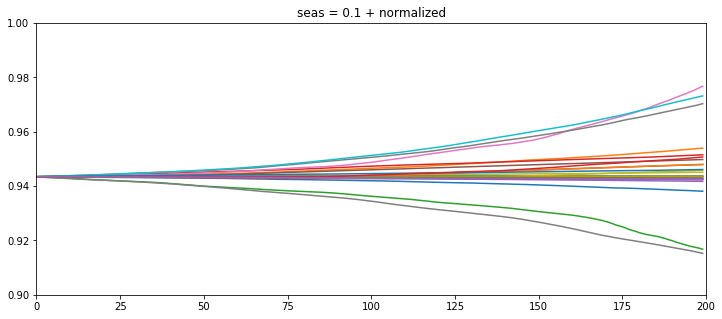

In [9]:
pd.DataFrame(data_01_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              ylim=(.9,1), xlim=(0, 200),
                              title='seas = 0.1 + normalized');

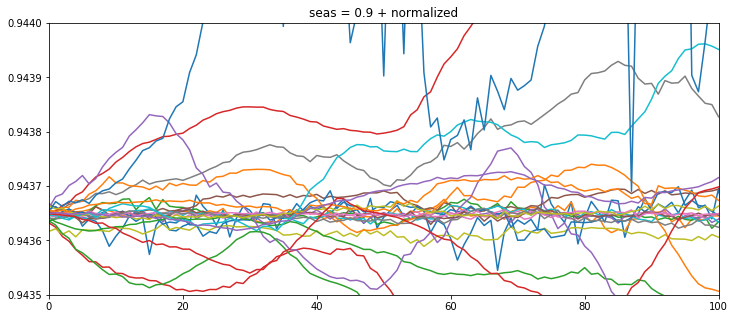

In [202]:
pd.DataFrame(data_09_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              ylim=(.9435,.944), xlim=(0, 100),
                              title='seas = 0.9 + normalized');

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [11]:
def mse(Y, YH):
     return np.square(Y - YH).mean()
    

def train_test_split_reshape(data, n_steps_for_train=175):
    """reshape + split train test 50-50"""
    np.random.shuffle(data)
    n_samples = data.shape[0]
    x_train = data[:n_samples/2, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_train = data[:n_samples/2, n_steps_for_train:]

    x_test = data[n_samples/2:, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_test = data[n_samples/2:, n_steps_for_train:]
    return x_train, y_train, x_test, y_test


In [15]:
def cnn_model(x_train, y_train, batch_size, epochs=100, n_steps_for_train=175):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=200-input_dim, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

## CNN for 2 cluster together

In [16]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_09_norm)

In [17]:
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 7000 samples, validate on 3000 samples
Epoch 1/15
 - 4s - loss: 0.0092 - mean_absolute_error: 0.0164 - val_loss: 6.1149e-05 - val_mean_absolute_error: 0.0028
Epoch 2/15
 - 4s - loss: 7.7591e-05 - mean_absolute_error: 0.0034 - val_loss: 6.1397e-05 - val_mean_absolute_error: 0.0033
Epoch 3/15
 - 4s - loss: 7.6904e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9662e-05 - val_mean_absolute_error: 0.0025
Epoch 4/15
 - 4s - loss: 7.6651e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9320e-05 - val_mean_absolute_error: 0.0025
Epoch 5/15
 - 4s - loss: 7.6388e-05 - mean_absolute_error: 0.0034 - val_loss: 5.9069e-05 - val_mean_absolute_error: 0.0024
Epoch 6/15
 - 4s - loss: 7.6294e-05 - mean_absolute_error: 0.0033 - val_loss: 6.3513e-05 - val_mean_absolute_error: 0.0034
Epoch 7/15
 - 4s - loss: 7.5650e-05 - mean_absolute_error: 0.0033 - val_loss: 5.9390e-05 - val_mean_absolute_error: 0.0027
Epoch 8/15
 - 4s - loss: 7.5247e-05 - mean_absolute_error: 0.0033 - val_loss: 5.8506e-05 - val_

## CNN for "low seasonality cluster"

In [25]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 3500 samples, validate on 1500 samples
Epoch 1/15
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0283 - val_loss: 1.4559e-04 - val_mean_absolute_error: 0.0055
Epoch 2/15
 - 1s - loss: 1.8801e-04 - mean_absolute_error: 0.0063 - val_loss: 1.4562e-04 - val_mean_absolute_error: 0.0063
Epoch 3/15
 - 1s - loss: 1.8706e-04 - mean_absolute_error: 0.0063 - val_loss: 1.4468e-04 - val_mean_absolute_error: 0.0055
Epoch 4/15
 - 1s - loss: 1.8559e-04 - mean_absolute_error: 0.0063 - val_loss: 1.6031e-04 - val_mean_absolute_error: 0.0080
Epoch 5/15
 - 1s - loss: 1.8462e-04 - mean_absolute_error: 0.0064 - val_loss: 1.4653e-04 - val_mean_absolute_error: 0.0066
Epoch 6/15
 - 1s - loss: 1.8561e-04 - mean_absolute_error: 0.0063 - val_loss: 1.4116e-04 - val_mean_absolute_error: 0.0054
Epoch 7/15
 - 1s - loss: 1.8314e-04 - mean_absolute_error: 0.0063 - val_loss: 1.5321e-04 - val_mean_absolute_error: 0.0062
Epoch 8/15
 - 1s - loss: 1.8321e-04 - mean_absolute_error: 0.0063 - val_loss: 1.4277e-04 - val_

In [41]:
x_test[0, :]

array([[0.94340115],
       [0.94337685],
       [0.94335099],
       [0.94332214],
       [0.94329859],
       [0.94326795],
       [0.9432444 ],
       [0.94321374],
       [0.94318915],
       [0.94316171],
       [0.94313434],
       [0.94310584],
       [0.94308024],
       [0.9430526 ],
       [0.94302458],
       [0.94298948],
       [0.94296722],
       [0.94293767],
       [0.94291154],
       [0.94288959],
       [0.94286355],
       [0.94283982],
       [0.94281486],
       [0.94278875],
       [0.94276018],
       [0.94273603],
       [0.9427107 ],
       [0.94268506],
       [0.94265611],
       [0.94262895],
       [0.94259698],
       [0.94256734],
       [0.94253997],
       [0.94251749],
       [0.94249011],
       [0.94246704],
       [0.94244256],
       [0.9424142 ],
       [0.942384  ],
       [0.94235554],
       [0.94232282],
       [0.94229499],
       [0.94226599],
       [0.94223701],
       [0.94221066],
       [0.94218192],
       [0.94215363],
       [0.942

In [40]:
x_test[0,-1]

array([0.94067328])

In [42]:
y_pred = model.predict(x_test)
naive_pred = 0
for i in range(x_test.shape[0]): 
    naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
naive_pred /= y_test.shape[0]
print naive_pred

0.0012050957287074043


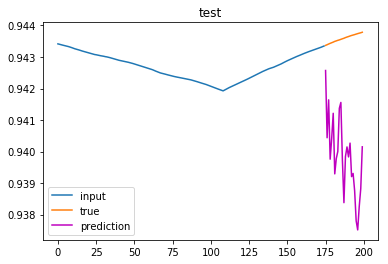

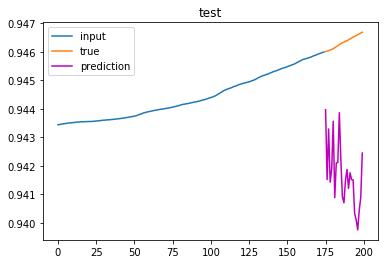

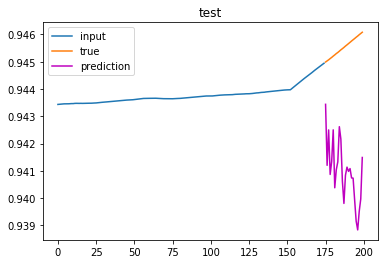

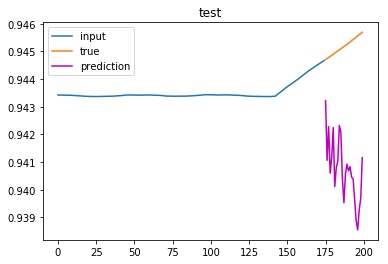

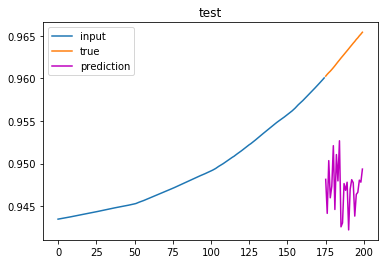

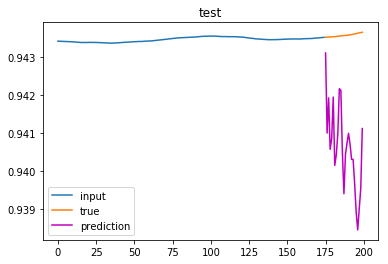

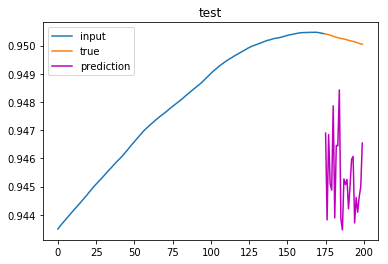

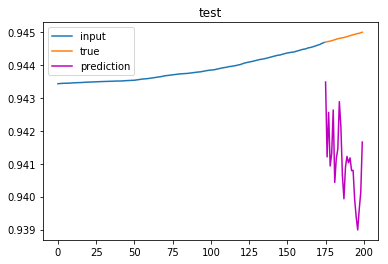

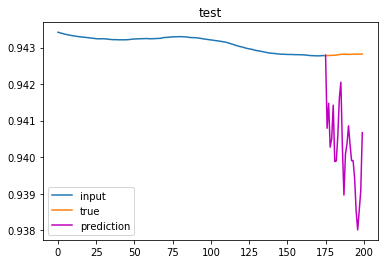

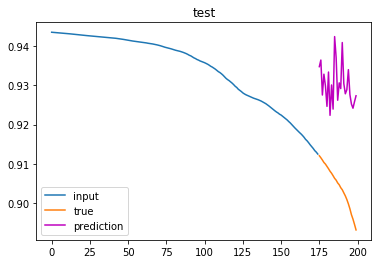

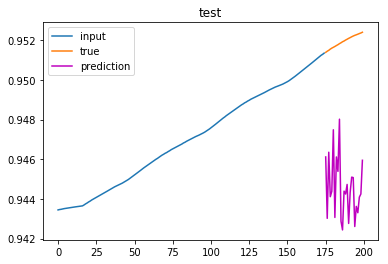

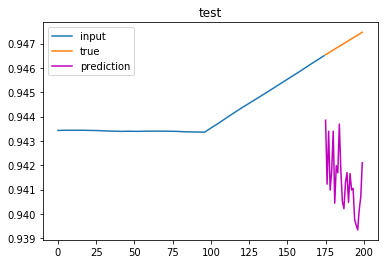

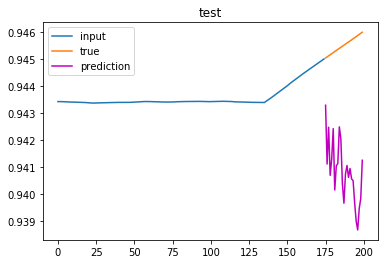

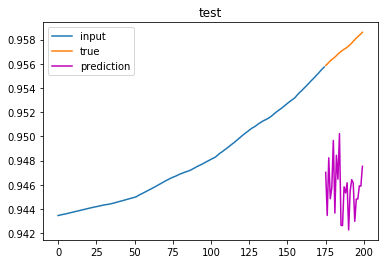

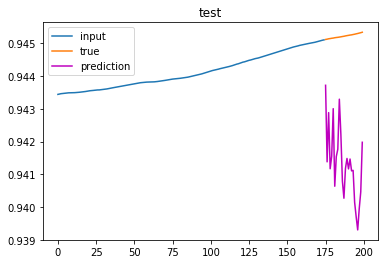

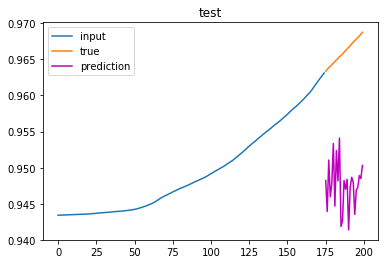

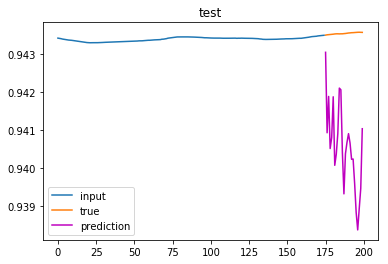

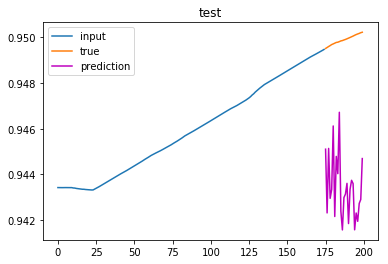

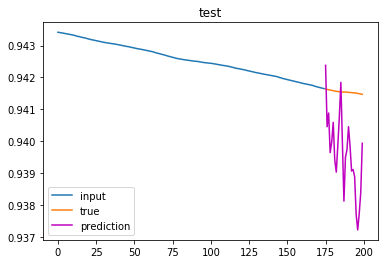

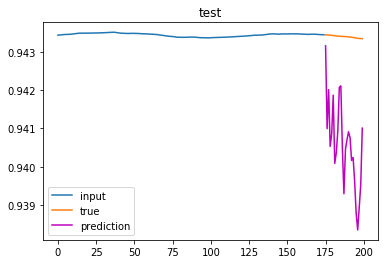

In [22]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## CNN for "high seasonality cluster"

In [43]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_09_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 3500 samples, validate on 1500 samples
Epoch 1/15
 - 2s - loss: 0.0206 - mean_absolute_error: 0.0338 - val_loss: 1.4898e-06 - val_mean_absolute_error: 4.1355e-04
Epoch 2/15
 - 1s - loss: 5.2669e-06 - mean_absolute_error: 4.8198e-04 - val_loss: 1.4155e-06 - val_mean_absolute_error: 3.7170e-04
Epoch 3/15
 - 1s - loss: 5.2071e-06 - mean_absolute_error: 4.8071e-04 - val_loss: 1.4851e-06 - val_mean_absolute_error: 4.9927e-04
Epoch 4/15
 - 1s - loss: 5.1817e-06 - mean_absolute_error: 4.8704e-04 - val_loss: 1.4671e-06 - val_mean_absolute_error: 4.6716e-04
Epoch 5/15
 - 1s - loss: 5.1376e-06 - mean_absolute_error: 4.8353e-04 - val_loss: 1.3940e-06 - val_mean_absolute_error: 3.2402e-04
Epoch 6/15
 - 1s - loss: 5.1132e-06 - mean_absolute_error: 4.8245e-04 - val_loss: 1.3909e-06 - val_mean_absolute_error: 3.2985e-04
Epoch 7/15
 - 1s - loss: 5.0665e-06 - mean_absolute_error: 4.7777e-04 - val_loss: 1.3654e-06 - val_mean_absolute_error: 3.2184e-04
Epoch 8/15
 - 1s - loss: 5.0139e-06 - mean_

In [44]:
y_pred = model.predict(x_test)
naive_pred = 0
for i in range(x_test.shape[0]): 
    naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
naive_pred /= y_test.shape[0]
print naive_pred

0.00010950036847713387


In [47]:
3e-4

0.0003

In [46]:
(naive_pred - 3e-4) / naive_pred

-1.7397168080091592

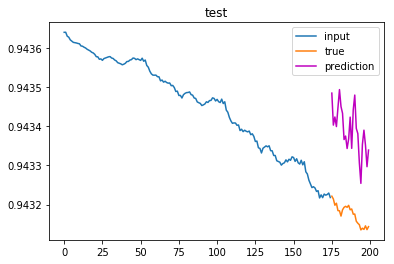

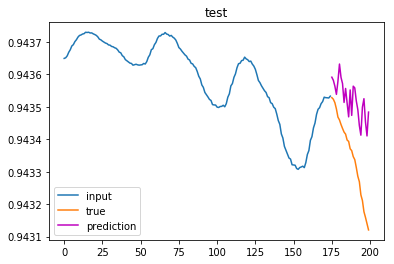

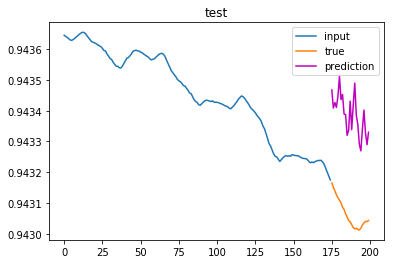

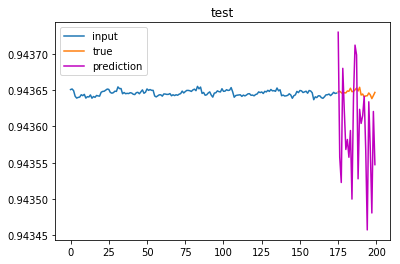

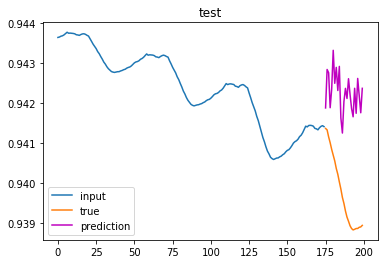

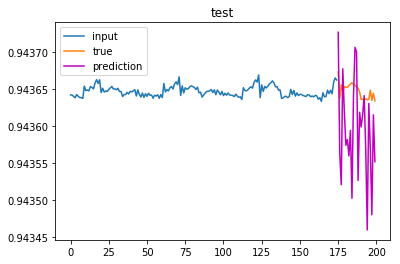

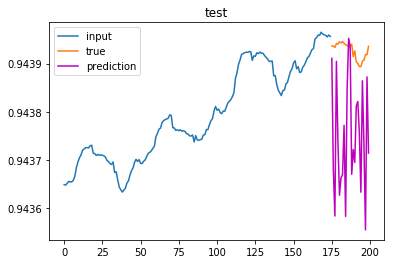

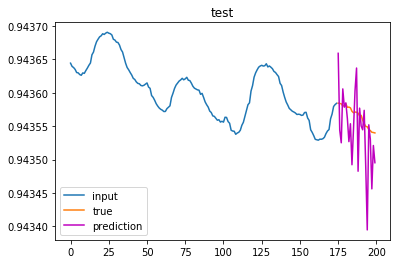

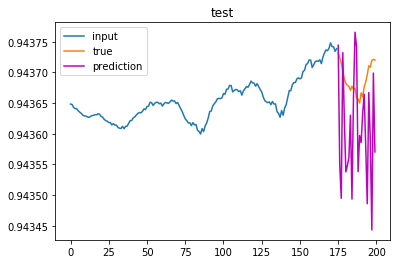

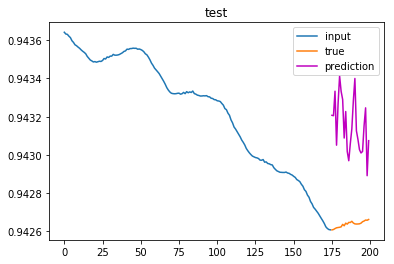

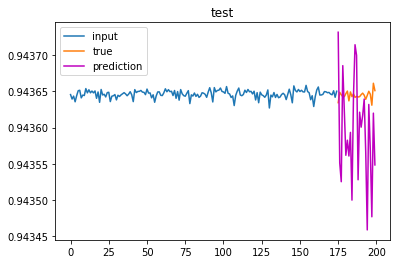

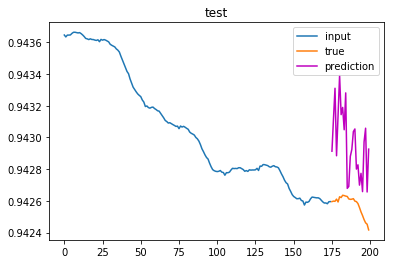

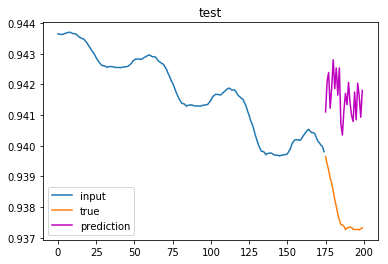

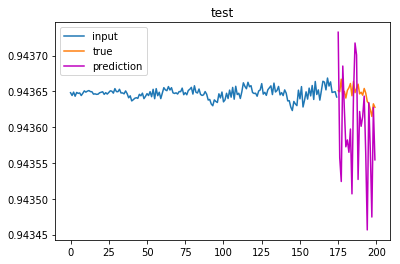

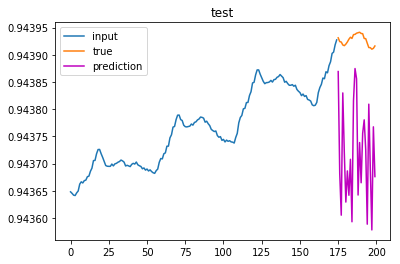

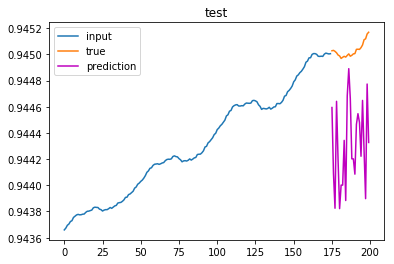

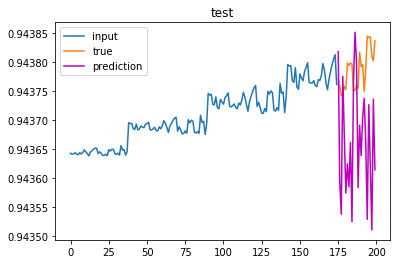

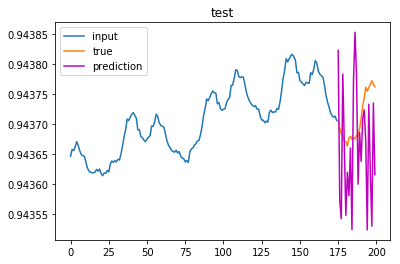

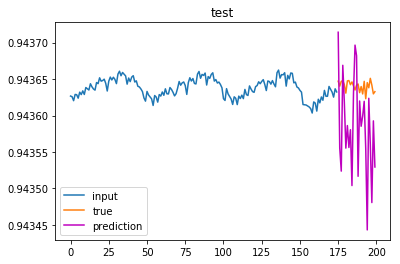

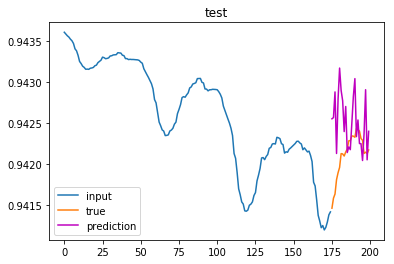

In [24]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

In [251]:
np.set_printoptions(precision=3, threshold=None, edgeitems=None, linewidth=None, suppress=True)

In [256]:
r01 = 3.7819e-06
r09 = 1.3042e-04
r_01_plus_09 = (r01 + r09) / 2
print r_01_plus_09

6.710095e-05


In [257]:
r_0109 = 1.1452e-04
print r_0109

0.00011452


In [263]:
print 'res = {0:0.4f}'.format(np.abs(r_01_plus_09 - r_01_09) / r_01_plus_09)

res = 0.7067


In [ ]:
y_pred = model.predict(x_test)

# random_indexes = range(data_numpy.shape[0]/2)
# random.shuffle(random_indexes)

for i in range(20):
    plt.figure()
    plt.plot(range(475), x_train[i], label='input')
    plt.plot(range(475, 500), y_test[i], label='true')
    plt.plot(range(475, 500), y_pred_test[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()